In [1]:
import os 
import sys 
import pandas as pd 
import zipfile 
import csv
from openpyxl import load_workbook
import time
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt 
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6
%matplotlib inline

D:\Users\KMatharoo\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Ideas 

- Try use AWS and other packages instead of purely python (pyspark)
- Create an interactive map of the trip journey (static and put on Github) 
- Create 'hotspots' of start and ending journeys 
- Generate some stats...
- Can we take the lat/long and identify it's towns and cities (https://geographic.org/streetview/usa/ca/los_angeles/index.html) 
- Can we use Google Places API, or something equivalent if it isn't free, to find popular places that can tell us about consumer behaviour and filter by year/category

- Comparative Analysis 
    - Is it possible to compare bike jounreys aganist cabs in LA or if another state (depends on data)? 
        - What is faster?
        - What is cheaper?

- https://bikeshare.metro.net/about/data/
    - Single Ride costs 1.75 dollars trip one ride up to 30 mintues 
    - Day Pass 5 dollars: unlimited 30-minute rides in a 24-hour period 
    - Monthly Membership: 17 dollars a year, unlimited 30-minute rides

# Importing data 

###### Define Variables 

In [2]:
# current directory 
current_dir = os.getcwd()
file_name = 'Data\los-angeles-metro-bike-share-trip-data.zip'
output_path = os.path.join( current_dir , 'Data')
full_path = (output_path + '\\' + 'metro-bike-share-trip-data.csv')
data_path = os.path.join(current_dir , file_name)
mapping_of_station = 'metro-bike-share-stations-2017-02-09.csv'
full_path_mapping = (output_path + '\\' + mapping_of_station)

In [3]:
# Unzip file 
zip_ref = zipfile.ZipFile( data_path , 'r')
zip_ref.extractall(output_path)

In [6]:
# Read in CSV using Pandas 
la_trips = pd.read_csv(filepath_or_buffer = full_path  ).drop(['Starting Lat-Long' , 'Ending Lat-Long'], axis = 1 )

D:\Users\KMatharoo\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
la_trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132427 entries, 0 to 132426
Data columns (total 14 columns):
Trip ID                       132427 non-null int64
Duration                      132427 non-null int64
Start Time                    132427 non-null object
End Time                      132427 non-null object
Starting Station ID           132408 non-null float64
Starting Station Latitude     132379 non-null float64
Starting Station Longitude    132379 non-null float64
Ending Station ID             132331 non-null float64
Ending Station Latitude       131376 non-null float64
Ending Station Longitude      131376 non-null float64
Bike ID                       132417 non-null float64
Plan Duration                 131661 non-null float64
Trip Route Category           132427 non-null object
Passholder Type               132427 non-null object
dtypes: float64(8), int64(2), object(4)
memory usage: 14.1+ MB


In [9]:
# Reading in the mapping file for station ID to station name 
metro_bike_mapping = pd.read_csv( filepath_or_buffer = full_path_mapping, usecols = ['Station_ID' , 'Station_Name'] )

In [10]:
starting_station = metro_bike_mapping.rename(columns = {'Station_ID': 'Starting Station ID', 'Station_Name' : 'Starting Station Name'})
ending_station = metro_bike_mapping.rename(columns = {'Station_ID': 'Ending Station ID', 'Station_Name' : 'Ending Station Name'})

In [11]:
starting_station.head()

Starting Station ID Starting Station Name
0                 3000       Virtual Station
1                 3005          7th & Flower
2                 3006           Olive & 8th
3                 3007           5th & Grand
4                 3008        Figueroa & 9th

In [16]:
# Mapping the starting and ending station to the main dataset 
la_trips_idx = pd.merge(la_trips, right = starting_station, on = 'Starting Station ID' , how = 'inner')
la_trips_idx = pd.merge(la_trips_idx, right = ending_station, on = 'Ending Station ID' , how = 'inner')

In [17]:
la_trips_idx.head()

Trip ID  Duration           Start Time             End Time  \
0  1912818       180  2016-07-07T04:17:00  2016-07-07T04:20:00   
1  1919661      1980  2016-07-07T06:00:00  2016-07-07T06:33:00   
2  1944030       120  2016-07-07T13:22:00  2016-07-07T13:24:00   
3  1943988       240  2016-07-07T13:41:00  2016-07-07T13:45:00   
4  1972684      1620  2016-07-07T19:55:00  2016-07-07T20:22:00   

  Starting Station ID  Starting Station Latitude  Starting Station Longitude  \
0                3014                   34.05661                  -118.23721   
1                3014                   34.05661                  -118.23721   
2                3014                   34.05661                  -118.23721   
3                3014                   34.05661                  -118.23721   
4                3014                   34.05661                  -118.23721   

  Ending Station ID  Ending Station Latitude  Ending Station Longitude  \
0              3014                 34.05661                -118.23721   
1              3014                 34.05661                -118.23721   
2              3014                 34.05661                -118.23721   
3              3014                 34.05661                -118.23721   
4              3014                 34.05661                -118.23721   

   Bike ID  Plan Duration Trip Route Category Passholder Type  \
0   6281.0           30.0          Round Trip    Monthly Pass   
1   6281.0           30.0          Round Trip    Monthly Pass   
2   6185.0           30.0          Round Trip    Monthly Pass   
3   6370.0           30.0          Round Trip    Monthly Pass   
4   6634.0           30.0          Round Trip    Monthly Pass   

       Starting Station Name        Ending Station Name  
0  Union Station West Portal  Union Station West Portal  
1  Union Station West Portal  Union Station West Portal  
2  Union Station West Portal  Union Station West Portal  
3  Union Station West Portal  Union Station West Portal  
4  Union Station West Portal  Union Station West Portal

In [18]:
la_trips_idx['Start Time'] = pd.to_datetime(la_trips_idx['Start Time'])
la_trips_idx['Start Date'] = [ s_date.date() for s_date in la_trips_idx['Start Time' ] ]

#Converting to datetime
la_trips_idx['End Time'] = pd.to_datetime(la_trips_idx['End Time'])
la_trips_idx['End Date'] = [ s_date.date() for s_date in la_trips_idx['End Time' ] ]

In [24]:
# Convert both dates to datetime data type 
la_trips_idx['Start Date'] = pd.to_datetime( la_trips_idx['Start Date'] )
la_trips_idx['End Date'] = pd.to_datetime( la_trips_idx['End Date'] )

In [25]:
la_trips_idx['Passholder Type'].unique()

array(['Monthly Pass', 'Flex Pass', 'Walk-up', 'Staff Annual'], dtype=object)

In [26]:
# Define the conditions we want to use 
conditions = [ (la_trips_idx['Plan Duration'] == 30) , (la_trips_idx['Passholder Type'] == 'Monthly Pass' ),
              (la_trips_idx['Plan Duration'] == 0) , (la_trips_idx['Plan Duration'] == 365) ]

# Define the results of those conditions 
choices = [17, 17 , 1.75 , 150]

In [27]:
# Use np.select to take those conditions and choices https://docs.scipy.org/doc/numpy/reference/generated/numpy.select.html 
la_trips_idx['Estimated Cost ($)'] = np.select( conditions , choices , default= np.nan)

In [28]:
la_trips_idx.head()

Trip ID  Duration          Start Time            End Time  \
0  1912818       180 2016-07-07 04:17:00 2016-07-07 04:20:00   
1  1919661      1980 2016-07-07 06:00:00 2016-07-07 06:33:00   
2  1944030       120 2016-07-07 13:22:00 2016-07-07 13:24:00   
3  1943988       240 2016-07-07 13:41:00 2016-07-07 13:45:00   
4  1972684      1620 2016-07-07 19:55:00 2016-07-07 20:22:00   

  Starting Station ID  Starting Station Latitude  Starting Station Longitude  \
0                3014                   34.05661                  -118.23721   
1                3014                   34.05661                  -118.23721   
2                3014                   34.05661                  -118.23721   
3                3014                   34.05661                  -118.23721   
4                3014                   34.05661                  -118.23721   

  Ending Station ID  Ending Station Latitude  Ending Station Longitude  \
0              3014                 34.05661                -118.23721   
1              3014                 34.05661                -118.23721   
2              3014                 34.05661                -118.23721   
3              3014                 34.05661                -118.23721   
4              3014                 34.05661                -118.23721   

   Bike ID  Plan Duration Trip Route Category Passholder Type  \
0   6281.0           30.0          Round Trip    Monthly Pass   
1   6281.0           30.0          Round Trip    Monthly Pass   
2   6185.0           30.0          Round Trip    Monthly Pass   
3   6370.0           30.0          Round Trip    Monthly Pass   
4   6634.0           30.0          Round Trip    Monthly Pass   

       Starting Station Name        Ending Station Name Start Date   End Date  \
0  Union Station West Portal  Union Station West Portal 2016-07-07 2016-07-07   
1  Union Station West Portal  Union Station West Portal 2016-07-07 2016-07-07   
2  Union Station West Portal  Union Station West Portal 2016-07-07 2016-07-07   
3  Union Station West Portal  Union Station West Portal 2016-07-07 2016-07-07   
4  Union Station West Portal  Union Station West Portal 2016-07-07 2016-07-07   

   Estimated Cost ($)  
0                17.0  
1                17.0  
2                17.0  
3                17.0  
4                17.0

In [29]:
la_trips_idx.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132130 entries, 0 to 132129
Data columns (total 19 columns):
Trip ID                       132130 non-null int64
Duration                      132130 non-null int64
Start Time                    132130 non-null datetime64[ns]
End Time                      132130 non-null datetime64[ns]
Starting Station ID           132130 non-null object
Starting Station Latitude     132101 non-null float64
Starting Station Longitude    132101 non-null float64
Ending Station ID             132130 non-null object
Ending Station Latitude       131177 non-null float64
Ending Station Longitude      131177 non-null float64
Bike ID                       132125 non-null float64
Plan Duration                 131425 non-null float64
Trip Route Category           132130 non-null object
Passholder Type               132130 non-null object
Starting Station Name         132130 non-null object
Ending Station Name           132130 non-null object
Start Date           

# Time Series 

- https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

- There are three basic criterion for a series to be classifie as stationary series: 
    - 1) The mean of the series should not be a function of time rather should be a constant
    - 2) The variance of the series should not a be a function of time. This property is known as homoscedasticity. 
    - 3) The covariance of the i th term and the (i + m) th term should not be a function of time

- http://strftime.org/ 

In [33]:
# columns we want to look at for time series ( Start and End Date )
feature_columns = la_trips_idx.loc[:,['Trip ID' , 'Start Date' , 'End Date', 'Estimated Cost ($)']]

In [34]:
# Sorting by Start Date to get a chronological timeline 
start_date_sorted = feature_columns.sort_values(by = 'Start Date')

In [35]:
start_date = start_date_sorted.loc[:, ['Trip ID' , 'Start Date']]

In [36]:
# Computing a count to see how many trips are started by date 
start_date_count = start_date.groupby('Start Date')['Trip ID'].count().rename(columns = {'Trip ID' : 'Count'})

A TS is said to be stationary if its statistical properties such as mean, variance remain constant over time. But why is it important? Most of the TS models work on the assumption that the TS is stationary. Intuitively, we can sat that if a TS has a particular behaviour over time, there is a very high probability that it will follow the same in the future. Also, the theories related to stationary series are more mature and easier to implement as compared to non-stationary series.

Stationarity is defined using very strict criterion. However, for practical purposes we can assume the series to be stationary if it has constant statistical properties over time, ie. the following:

- 1) constant mean
- 2) constant variance
- 3) an autocovariance that does not depend on time.

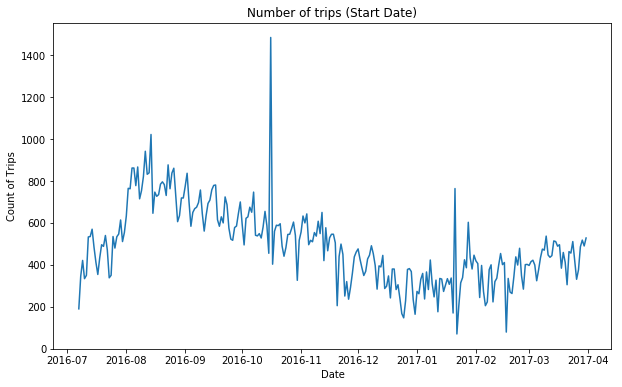

In [75]:
# Plotting 
plt.figure(figsize = ( 10, 6))
plt.title("Number of trips (Start Date)")
plt.xlabel("Date")
plt.ylabel("Count of Trips")
plt.plot( start_date_count )
plt.savefig('./Data/startDate.png')
plt.show()

- We can check stationarity using: 
    - 1)  Plotting Rolling Statistics 
        - At any instance 't', we'll take the avarage/variance of the last year 
        
    - 2) Dickey-Fuller test
        - This test comprise of a **Test Statistic** and some **Critical Values** for difference in confidence levels 
        - If the **Test Statistic** is less than the **Critical Value**, we reject the null hypothesis and say that the series is stationary

In [38]:
def test_stationarity( timeseries ):
    
    # Determining rolling statistics 
    #rolmean  = pd.rolling_mean( timeseries, window = 12)
    #rolstd = pd.rolling_std( timeseries , window = 12)
    rolmean = pd.Series.rolling( timeseries , window = 12 , center = False).mean()
    rolstd = pd.Series.rolling( timeseries , window = 12 , center = False).std()
    
    # Plot rolling statistics 
    plt.figure(figsize = ( 10, 6))
    orig = plt.plot( timeseries, color = 'blue' , label = 'Original')
    mean = plt.plot( rolmean , color = 'red' , label = 'Rolling Mean')
    std = plt.plot( rolstd, color = 'black' , label = 'Rolling Std')
    plt.legend( loc = 'best')
    plt.title( 'Rolling Mean and Standard Deviation')
    plt.show( block = False)
    
    # Perform Dickey-Fuller test 
    print ('Results of Dickey-Fuller Test: ')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series( dftest[0:4], index = ['Test Statistic' , 'P-Value' , '#Lags Used' , 'Number pf Observations Used'])
    
    for key, value in dftest[4].items():
        
        dfoutput['Critical Value %s'% key] = value 
        
    print (dfoutput)

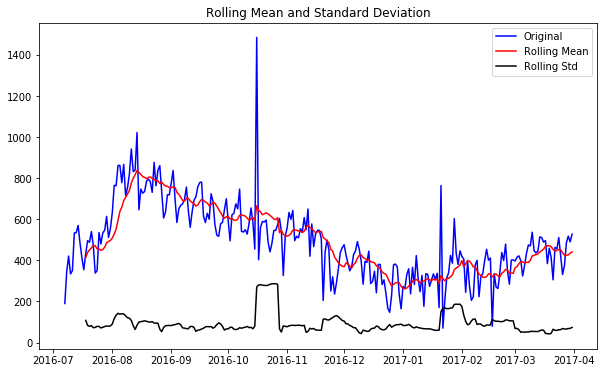

Results of Dickey-Fuller Test: 
Test Statistic                  -1.495300
P-Value                          0.535835
#Lags Used                       6.000000
Number pf Observations Used    261.000000
Critical Value 1%               -3.455656
Critical Value 5%               -2.872678
Critical Value 10%              -2.572705
dtype: float64


In [39]:
test_stationarity(start_date_count)

### How to make a Time Series Stationary 

- There are two major reasons behind non-stationaruty of a TS:
    - 1) **Trend**: varying mean over time.
    - 2) **Seasonality**: Variations at specific time-frames
- The principle is to model or estiamte the trend and seasonality in the series and remove those from the the series to get a stationary series. Then statistical forecasting techniques can be implemented on this series 

- It is easy to see a forward trend in the data, but it's not very intuitive in presence of noise 
- We can use the following to deal with noise: 
    - 1) **Aggregation** : Taking average for a time period like monthly/weekly averages 
    - 2) **Smoothing**: Taking rolling averages 
    - 3) **Polynomial Fitting**: Fit a regression model 

### Moving Average

- We take average of **K** consecutive values depending on the frequency of time series 

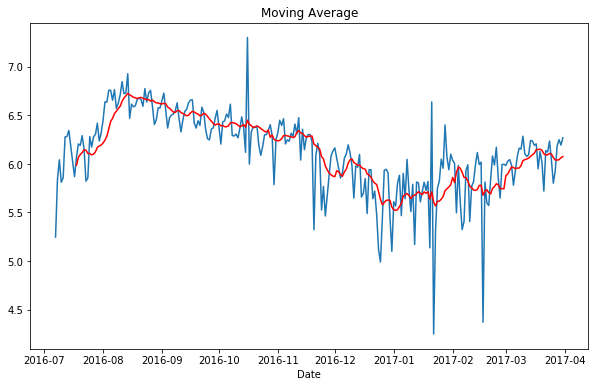

In [140]:
ts_log = np.log( start_date_count)
moving_avg = pd.Series.rolling( ts_log , 12 ).mean()
plt.figure(figsize = ( 10, 6))
plt.title("Moving Average")
plt.xlabel("Date")
plt.plot( ts_log)
plt.plot( moving_avg, color = 'red')
plt.savefig('./Data/MovingAverage.png')
plt.show()

In [41]:
ts_log_moving_avg_diff = ts_log - moving_avg

In [42]:
ts_log_moving_avg_diff.dropna(inplace = True)

- We  can say with 99% confidence that this is now a stationary series  

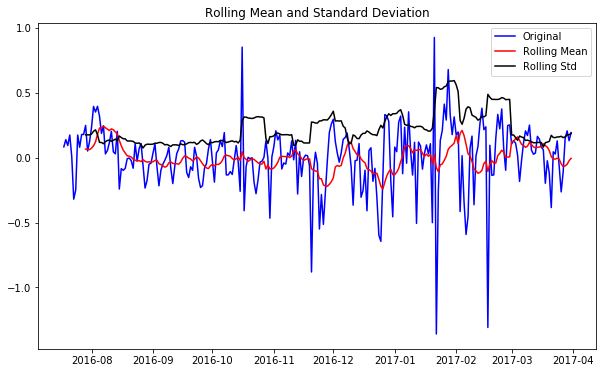

Results of Dickey-Fuller Test: 
Test Statistic                -5.658163e+00
P-Value                        9.514606e-07
#Lags Used                     8.000000e+00
Number pf Observations Used    2.480000e+02
Critical Value 1%             -3.456996e+00
Critical Value 5%             -2.873266e+00
Critical Value 10%            -2.573019e+00
dtype: float64


In [43]:
test_stationarity( ts_log_moving_avg_diff)

- However, a drawback in this particular approach is that the time-period has to be strictly defined. In this case we can take yearly averages but in complex situations like forecasting a stock price, its difficult to come up with a number. 
- So we take a ‘weighted moving average’ where more recent values are given a higher weight. There can be many technique for assigning weights
- **Exponentially weighted moving average**

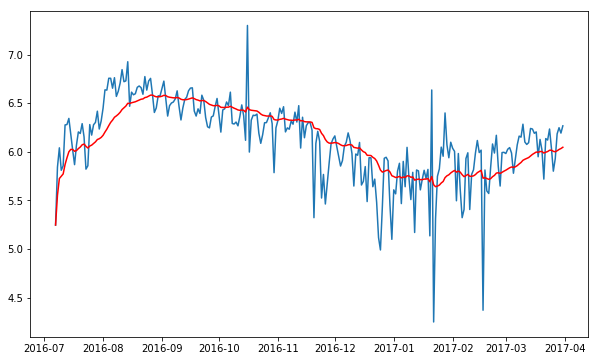

In [47]:
expweighted_avg = pd.Series.ewm( ts_log , halflife=12).mean() # halflife is used to define the amount of exponential decay 
plt.figure( figsize = (10,6))
plt.plot( ts_log )
plt.plot( expweighted_avg , color ='red')
plt.show()

- Let's remove this from the series and check stationarity 

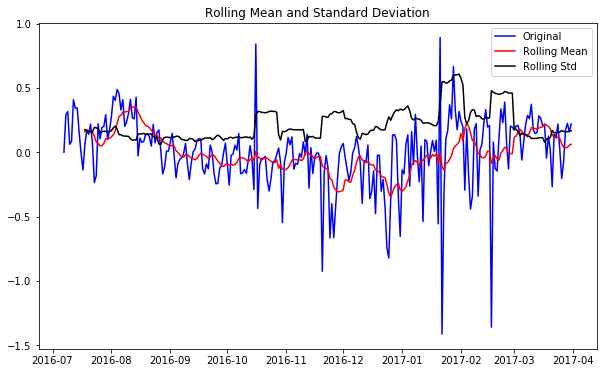

Results of Dickey-Fuller Test: 
Test Statistic                  -3.428741
P-Value                          0.010017
#Lags Used                       6.000000
Number pf Observations Used    261.000000
Critical Value 1%               -3.455656
Critical Value 5%               -2.872678
Critical Value 10%              -2.572705
dtype: float64


In [48]:
ts_log_ewma_diff = ts_log - expweighted_avg
test_stationarity( ts_log_ewma_diff)

### Eliminating Trend and Seasonality 

- Not all reduction techniques work, particularly the ones with high seasonality. Two ways of removing trend and seasonality 
    - 1) **Differencing** - taking the difference with a particular time lag 
    - 2) **Decomposition** - modeling both trend and seasonality and removing them from the model 

#### Differencing 
- First order differencing 

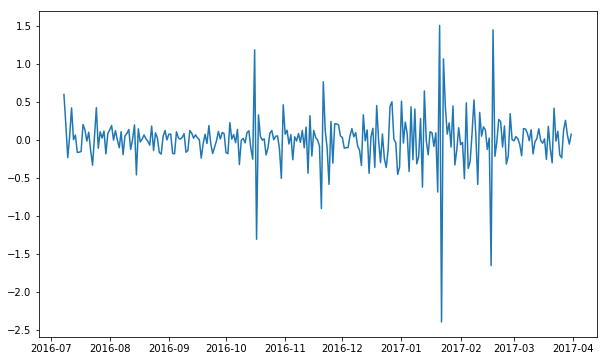

In [51]:
ts_log_diff = ts_log - ts_log.shift()
plt.figure( figsize = (10,6))
plt.plot( ts_log_diff )
plt.show()

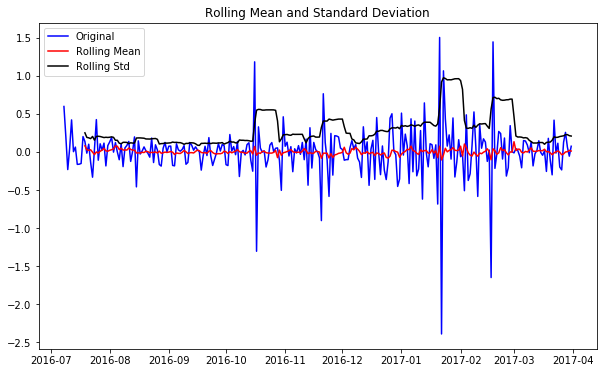

Results of Dickey-Fuller Test: 
Test Statistic                -1.234864e+01
P-Value                        5.893723e-23
#Lags Used                     5.000000e+00
Number pf Observations Used    2.610000e+02
Critical Value 1%             -3.455656e+00
Critical Value 5%             -2.872678e+00
Critical Value 10%            -2.572705e+00
dtype: float64


In [52]:
ts_log_diff.dropna(inplace = True)
test_stationarity( ts_log_diff )

#### Decomposing

In [53]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [54]:
decomposition = seasonal_decompose( ts_log )

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

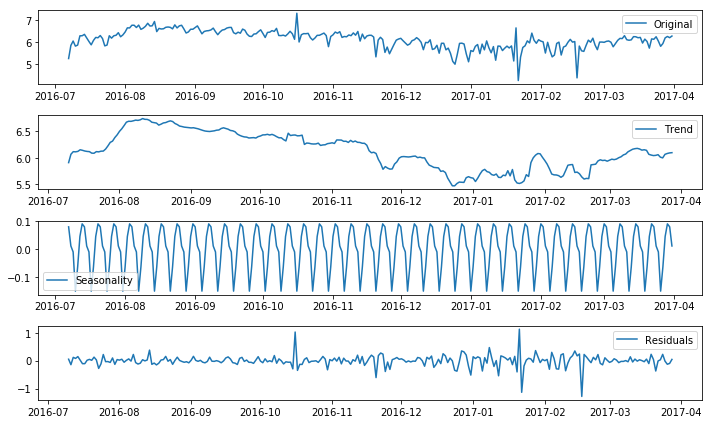

In [58]:
plt.figure( figsize = ( 10, 6))
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

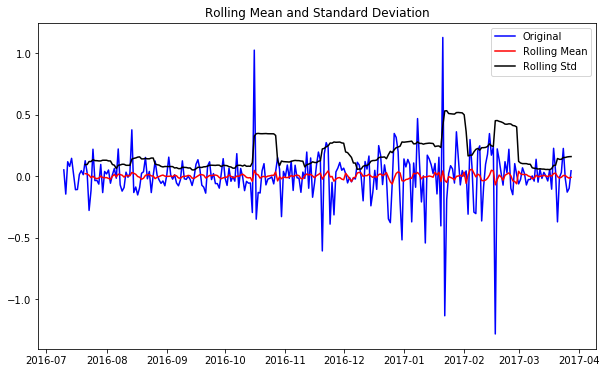

Results of Dickey-Fuller Test: 
Test Statistic                -7.312369e+00
P-Value                        1.254615e-10
#Lags Used                     1.600000e+01
Number pf Observations Used    2.450000e+02
Critical Value 1%             -3.457326e+00
Critical Value 5%             -2.873410e+00
Critical Value 10%            -2.573096e+00
dtype: float64


In [59]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

## Forecasting a Time Series

- After performing the trend and seasonality elimination techniques, there can be two situations:
    - 1) A **Strictly Stationary series** with no dependence among the values. This is the easy case wherein we can model the residuals as white nose but this is very rare 
    - 2) A series with significant **dependence among values**. We use ARIMA to forecast the data  

#### ARIMA

- **A**uto-**R**regressive **I**ntegreated **M**oving **A**verges forecasting for a stationary time series is nothing but a linear equation.
- The predictors depend of the parameters (p,d,q): 
    - **Number of AR (Auto-Regressive) terms (p)**: AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will x(t-1) .... x(t-5)
    - **Number of MA (Moving Average) terms (q)**: MA terms are lagged forecast errors in prediction equation. If q is 5, the predictors for x(t) will e(t-1)...e(t-5) where e(i) is the difference between the moving average at i-th instant and actual value 
    - **Number of Differences (d) **: These are number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass the variable and put d=0 or pass the original variable and put d=1. 

- How to determine the value of 'p' and 'q'. We use two plots to determine these: 
    - 1) **Autorcorrelation Function (ACF)**: It is a measure of the correlation between the TS with a lagged version of itself. For instance, at lag 5, ACF would compare series at time instant 't1'...'t2' with series at instant 't1-5'...'t2-5' (t1-5 and t2 being end points 
    - 2) **Partial Autocorrelation Function (PACF)**: This measures the correlation between the TS with a lagged version of itself but after elimination the variations alreay explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4 

In [60]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

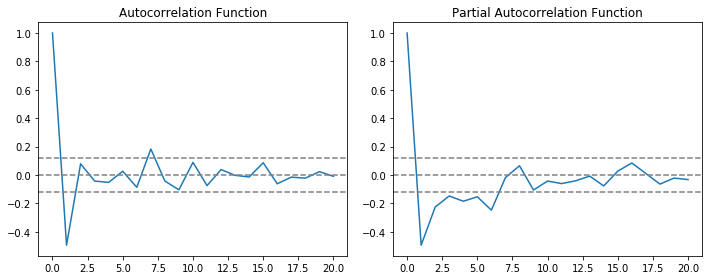

In [61]:
#Plot ACF: 
plt.figure(figsize = ( 10,4))

plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

- In this plot, the two dotted lines on either sides of 0 are the confidence interevals. These can be used to determine the ‘p’ and ‘q’ values as:
    - 1) p – The lag value where the PACF chart crosses the upper confidence interval for the first time.
    - 2) q - The lag value where the ACF chart crosses the upper confidence interval for the first time 

In [62]:
from statsmodels.tsa.arima_model import ARIMA


-  The p,d,q values can be specified using the order argument of ARIMA which take a tuple (p,d,q). Let model the 3 cases:

#### AR Model

Text(0.5,1,'RSS: 21.9091')

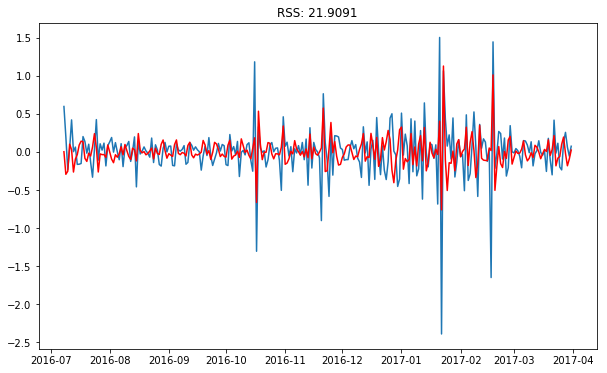

In [64]:
model = ARIMA( ts_log , order = (2,1,0))
results_AR = model.fit(disp=-1) 
plt.figure(figsize = (10,6))
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

#### MA Model

Text(0.5,1,'RSS: 19.7886')

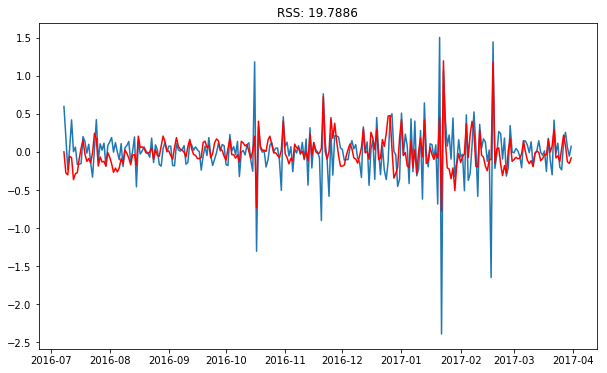

In [65]:
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.figure(figsize = (10,6))
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

#### Combined Model

Text(0.5,1,'RSS: 19.6270')

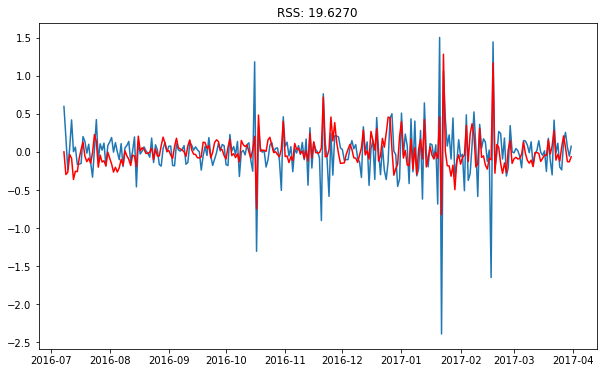

In [66]:
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.figure(figsize = (10,6))
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

In [68]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

Start Date
2016-07-08    0.000951
2016-07-09   -0.296777
2016-07-10   -0.267646
2016-07-11   -0.033744
2016-07-12   -0.083402
dtype: float64


In [70]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

Start Date
2016-07-08    0.000951
2016-07-09   -0.295826
2016-07-10   -0.563472
2016-07-11   -0.597216
2016-07-12   -0.680618
dtype: float64


In [71]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Start Date
2016-07-07    5.247024
2016-07-08    5.247975
2016-07-09    4.951198
2016-07-10    4.683552
2016-07-11    4.649808
dtype: float64

## Exporting Images and data to multiple Excel Worksheets

- Can we take some of the Plots above and export them to a specific excel worksheet and add some text? 
- Can we export different columns to different worksheets and allow for formatting 

In [81]:
la_trips_idx.head()

Trip ID  Duration          Start Time            End Time  \
0  1912818       180 2016-07-07 04:17:00 2016-07-07 04:20:00   
1  1919661      1980 2016-07-07 06:00:00 2016-07-07 06:33:00   
2  1944030       120 2016-07-07 13:22:00 2016-07-07 13:24:00   
3  1943988       240 2016-07-07 13:41:00 2016-07-07 13:45:00   
4  1972684      1620 2016-07-07 19:55:00 2016-07-07 20:22:00   

  Starting Station ID  Starting Station Latitude  Starting Station Longitude  \
0                3014                   34.05661                  -118.23721   
1                3014                   34.05661                  -118.23721   
2                3014                   34.05661                  -118.23721   
3                3014                   34.05661                  -118.23721   
4                3014                   34.05661                  -118.23721   

  Ending Station ID  Ending Station Latitude  Ending Station Longitude  \
0              3014                 34.05661                -118.23721   
1              3014                 34.05661                -118.23721   
2              3014                 34.05661                -118.23721   
3              3014                 34.05661                -118.23721   
4              3014                 34.05661                -118.23721   

   Bike ID  Plan Duration Trip Route Category Passholder Type  \
0   6281.0           30.0          Round Trip    Monthly Pass   
1   6281.0           30.0          Round Trip    Monthly Pass   
2   6185.0           30.0          Round Trip    Monthly Pass   
3   6370.0           30.0          Round Trip    Monthly Pass   
4   6634.0           30.0          Round Trip    Monthly Pass   

       Starting Station Name        Ending Station Name Start Date   End Date  \
0  Union Station West Portal  Union Station West Portal 2016-07-07 2016-07-07   
1  Union Station West Portal  Union Station West Portal 2016-07-07 2016-07-07   
2  Union Station West Portal  Union Station West Portal 2016-07-07 2016-07-07   
3  Union Station West Portal  Union Station West Portal 2016-07-07 2016-07-07   
4  Union Station West Portal  Union Station West Portal 2016-07-07 2016-07-07   

   Estimated Cost ($)  
0                17.0  
1                17.0  
2                17.0  
3                17.0  
4                17.0

In [84]:
start_date_count.head()

Start Date
2016-07-07    190
2016-07-08    345
2016-07-09    421
2016-07-10    334
2016-07-11    350
dtype: int64

In [141]:
filename = './Data/startDate.png'
filename2 = './Data/MovingAverage.png'
excel_book = './Data/LA_trip.xlsx'

In [120]:
start_date_count_reindex = start_date_count.reset_index()
start_date_count_reindex = start_date_count_reindex.rename( columns = {0 : 'Count'})
start_date_count_reindex['Start Date'] = start_date_count_reindex['Start Date'].astype(str)

In [121]:
end_date_sorted = feature_columns.sort_values(by = 'End Date')
end_date = end_date_sorted.loc[:,['Trip ID' , 'End Date']]
end_date_count = end_date.groupby('End Date')['Trip ID'].count().rename(columns = {0 : 'Count'}).reset_index()
end_date_count = end_date_count.rename( columns = {0 : 'Count'})
end_date_count['End Date'] = end_date_count['End Date'].astype(str)

In [122]:
la_trips_idx['Start Date'] = la_trips_idx['Start Date'].astype(str)
la_trips_idx['End Date'] = la_trips_idx['End Date'].astype(str)

In [123]:
# la_trips_idx
# start_date_count 
# end_date_count 
# images we add

dfs = {'LA Trip Data' : la_trips_idx , 'Count by Start Date' : start_date_count_reindex , 
       'Count by End Date' : end_date_count }

In [143]:
writer = pd.ExcelWriter(excel_book , engine = 'xlsxwriter')

workbook = writer.book # activate the workbook

workbook_sheets = ['LA Trip Data', 'Count by Start Date' , 'Count by End Date']

# Loop through the dataframe values 

for sheetname, df in dfs.items():
        
    worksheet =  workbook.add_worksheet(sheetname)
    
    writer.sheets[sheetname] = worksheet
    
    df.to_excel( writer , sheet_name = sheetname, index = False)
    
    length_of_df = len(df)
    
    length_of_col = len(df.columns) - 1 

    for idx, col in enumerate( df ):
        
        series = df[col]
        
        max_len = max (( 
                        series.astype(str).map(len).max(),
                        len(str(series.name))
                        )) + 5
            
        # Add a filter to all columns 
        worksheet.autofilter(first_row = 0,first_col = 0, last_row = length_of_df , last_col = length_of_col)
        
        # Set the column length at each index
        worksheet.set_column(idx , idx, max_len)
                        
        # Format the header
        header_format = workbook.add_format({
                        'bold' : True , 
                        'text_wrap' : True,
                        'valign': 'centre'
                        })        
        

worksheet =  workbook.add_worksheet('Images')
    
writer.sheets['Images'] = worksheet

worksheet.insert_image('A1' , filename, {'x_scale' : 0.5 , 'y_scale' : 0.5 }) # Reducing Image size 

worksheet.insert_image('A20' , filename2, {'x_scale' : 0.5 , 'y_scale' : 0.5 })

# Save and close the workbook
writer.save()
writer.close()